In [1]:
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
import torch 
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
import requests
import matplotlib.pyplot as plt

import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from accelerate import Accelerator

import logging
import sys

accelerator = Accelerator()
device = accelerator.device
# device = 'cuda:3'

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers.models.vit.modeling_vit import *

class ModViTForImageClassification(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__(config)

        self.num_labels = config.num_labels
        self.vit = ViTModel(config, add_pooling_layer=False, use_mask_token=True)

        # Classifier head
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) if config.num_labels > 0 else nn.Identity()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.vit(
            pixel_values,
            bool_masked_pos=bool_masked_pos,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            interpolate_pos_encoding=interpolate_pos_encoding,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.classifier(sequence_output[:, 0, :])

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

original_model = ViTForImageClassification.from_pretrained(pretrained_name)
state_dict = original_model.state_dict()
del original_model # remove the model to free up memory
# change to use_mask_token = True
pred_model = ModViTForImageClassification(config)
# load back the parameters from state_dict
# 为新的模型实例添加 mask_token 权重
if 'vit.embeddings.mask_token' not in state_dict:
    state_dict['vit.embeddings.mask_token'] = pred_model.vit.embeddings.mask_token

pred_model.load_state_dict(state_dict)

pred_model.to(device)
# set to eval mode
pred_model.eval()
print()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


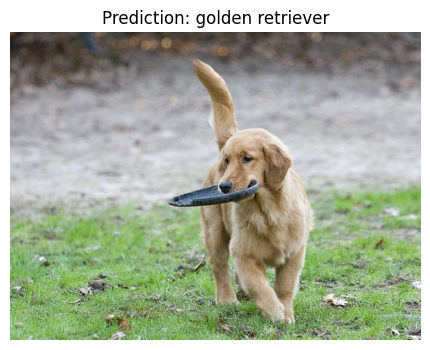

In [5]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = pred_model.config.id2label[predicted_class_idx]

plt.figure(figsize=(6, 4))  # 设置图像显示的大小
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

In [6]:
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

In [7]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()
dataset = load_dataset("mrm8488/ImageNet1K-val")['train']

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)
dataset.set_transform(preprocess)


batch_size = 16
# train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
# train_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [14]:
from tqdm import tqdm

optimizer = torch.optim.Adam(mask_gen_model.parameters(), lr=1e-6, weight_decay=1e-5)

for epoch in range(1):
    pbar = tqdm(train_dataloader)
    for idx, data in enumerate(pbar):
        pixel_values = data['pixel_values'].to(device)
        sim = mask_gen_model.forward(model=pred_model, pixel_values=pixel_values)
        mask, masked_pred_logits = mask_gen_model.sample_one_step(model=pred_model, pixel_values=pixel_values, sim=sim)
        pred_logits = mask_gen_model.get_pred_logits(model=pred_model, pixel_values=pixel_values)
        loss_dict = mask_gen_model.loss_func(sim=sim, mask=mask, masked_pred_logits=masked_pred_logits, pred_logits=pred_logits)
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}, Step {idx+1}: Loss = {loss_dict['loss'].item():.4f}, " 
                             f"Reward Loss = {loss_dict['reward_loss'].item():.4f}, "
                             f"Mask Loss = {loss_dict['mask_loss'].item():.4f} "
                             f"mask_mean = {loss_dict['mask_mean'].item():.4f} "
                             f"prob_mean = {loss_dict['prob_mean'].item():.4f} "
                             )
        if idx % 10 == 0:
            print()



Epoch 1, Step 1: Loss = 14.7616, Reward Loss = 14.1033, Mask Loss = 0.6583 mask_mean = 0.6352 prob_mean = 0.6322 :   0%|          | 1/3125 [00:00<24:02,  2.17it/s]

Epoch 1, Step 11: Loss = 21.9584, Reward Loss = 21.2735, Mask Loss = 0.6848 mask_mean = 0.6626 prob_mean = 0.6575 :   0%|          | 11/3125 [00:04<22:33,  2.30it/s]

Epoch 1, Step 21: Loss = 18.3809, Reward Loss = 17.6397, Mask Loss = 0.7411 mask_mean = 0.7168 prob_mean = 0.7149 :   1%|          | 21/3125 [00:08<21:18,  2.43it/s]

Epoch 1, Step 31: Loss = 18.5885, Reward Loss = 17.9195, Mask Loss = 0.6690 mask_mean = 0.6502 prob_mean = 0.6457 :   1%|          | 31/3125 [00:13<21:24,  2.41it/s]

Epoch 1, Step 41: Loss = 23.1382, Reward Loss = 22.4501, Mask Loss = 0.6881 mask_mean = 0.6690 prob_mean = 0.6659 :   1%|▏         | 41/3125 [00:17<20:16,  2.53it/s]

Epoch 1, Step 51: Loss = 22.3684, Reward Loss = 21.7087, Mask Loss = 0.6596 mask_mean = 0.6416 prob_mean = 0.6331 :   2%|▏         | 51/3125 [00:21<22:51,  2.24it/s]

Epoch 1, Step 61: Loss = 14.3113, Reward Loss = 13.6666, Mask Loss = 0.6446 mask_mean = 0.6218 prob_mean = 0.6288 :   2%|▏         | 61/3125 [00:25<20:38,  2.47it/s]

Epoch 1, Step 71: Loss = 19.0692, Reward Loss = 18.4049, Mask Loss = 0.6643 mask_mean = 0.6460 prob_mean = 0.6347 :   2%|▏         | 71/3125 [00:29<21:26,  2.37it/s]

Epoch 1, Step 81: Loss = 13.1830, Reward Loss = 12.4869, Mask Loss = 0.6961 mask_mean = 0.6738 prob_mean = 0.6688 :   3%|▎         | 81/3125 [00:33<20:46,  2.44it/s]

Epoch 1, Step 91: Loss = 19.5590, Reward Loss = 18.9060, Mask Loss = 0.6530 mask_mean = 0.6346 prob_mean = 0.6438 :   3%|▎         | 91/3125 [00:38<21:26,  2.36it/s]

Epoch 1, Step 101: Loss = 16.1477, Reward Loss = 15.4466, Mask Loss = 0.7012 mask_mean = 0.6795 prob_mean = 0.6899 :   3%|▎         | 101/3125 [00:42<20:54,  2.41it/s]

Epoch 1, Step 111: Loss = 7.8837, Reward Loss = 7.2130, Mask Loss = 0.6707 mask_mean = 0.6572 prob_mean = 0.6533 :   4%|▎         | 111/3125 [00:46<21:56,  2.29it/s]  

Epoch 1, Step 121: Loss = 21.1291, Reward Loss = 20.4510, Mask Loss = 0.6780 mask_mean = 0.6626 prob_mean = 0.6620 :   4%|▍         | 121/3125 [00:50<20:52,  2.40it/s]

Epoch 1, Step 131: Loss = 20.4311, Reward Loss = 19.7634, Mask Loss = 0.6677 mask_mean = 0.6505 prob_mean = 0.6578 :   4%|▍         | 131/3125 [00:54<18:26,  2.71it/s]

Epoch 1, Step 141: Loss = 17.9048, Reward Loss = 17.2018, Mask Loss = 0.7030 mask_mean = 0.6827 prob_mean = 0.6752 :   5%|▍         | 141/3125 [00:58<20:24,  2.44it/s]

Epoch 1, Step 151: Loss = 17.8577, Reward Loss = 17.1970, Mask Loss = 0.6607 mask_mean = 0.6409 prob_mean = 0.6383 :   5%|▍         | 151/3125 [01:02<18:40,  2.65it/s]

Epoch 1, Step 161: Loss = 18.9659, Reward Loss = 18.2934, Mask Loss = 0.6725 mask_mean = 0.6511 prob_mean = 0.6547 :   5%|▌         | 161/3125 [01:06<19:03,  2.59it/s]

Epoch 1, Step 171: Loss = 21.2013, Reward Loss = 20.4726, Mask Loss = 0.7287 mask_mean = 0.7101 prob_mean = 0.7143 :   5%|▌         | 171/3125 [01:09<17:26,  2.82it/s]

Epoch 1, Step 181: Loss = 18.8364, Reward Loss = 18.1444, Mask Loss = 0.6920 mask_mean = 0.6722 prob_mean = 0.6593 :   6%|▌         | 181/3125 [01:13<20:14,  2.42it/s]

Epoch 1, Step 191: Loss = 13.9595, Reward Loss = 13.2198, Mask Loss = 0.7396 mask_mean = 0.7203 prob_mean = 0.7197 :   6%|▌         | 191/3125 [01:18<22:06,  2.21it/s]

Epoch 1, Step 201: Loss = 12.0014, Reward Loss = 11.2458, Mask Loss = 0.7557 mask_mean = 0.7363 prob_mean = 0.7280 :   6%|▋         | 201/3125 [01:22<20:05,  2.43it/s]

Epoch 1, Step 211: Loss = 13.7083, Reward Loss = 12.9842, Mask Loss = 0.7241 mask_mean = 0.7127 prob_mean = 0.6976 :   7%|▋         | 211/3125 [01:26<18:18,  2.65it/s]

Epoch 1, Step 221: Loss = 24.5754, Reward Loss = 23.8184, Mask Loss = 0.7569 mask_mean = 0.7443 prob_mean = 0.7511 :   7%|▋         | 221/3125 [01:30<19:01,  2.54it/s]

Epoch 1, Step 231: Loss = 15.0689, Reward Loss = 14.3280, Mask Loss = 0.7410 mask_mean = 0.7286 prob_mean = 0.7167 :   7%|▋         | 231/3125 [01:33<19:03,  2.53it/s]

Epoch 1, Step 241: Loss = 21.5200, Reward Loss = 20.8497, Mask Loss = 0.6703 mask_mean = 0.6515 prob_mean = 0.6496 :   8%|▊         | 241/3125 [01:37<20:42,  2.32it/s]

Epoch 1, Step 251: Loss = 14.1845, Reward Loss = 13.4583, Mask Loss = 0.7262 mask_mean = 0.7079 prob_mean = 0.7100 :   8%|▊         | 251/3125 [01:41<18:48,  2.55it/s]

Epoch 1, Step 261: Loss = 19.4434, Reward Loss = 18.7382, Mask Loss = 0.7053 mask_mean = 0.6837 prob_mean = 0.6897 :   8%|▊         | 261/3125 [01:45<17:18,  2.76it/s]

Epoch 1, Step 271: Loss = 15.2589, Reward Loss = 14.5169, Mask Loss = 0.7421 mask_mean = 0.7232 prob_mean = 0.7120 :   9%|▊         | 271/3125 [01:49<18:51,  2.52it/s]

Epoch 1, Step 281: Loss = 16.1165, Reward Loss = 15.3592, Mask Loss = 0.7572 mask_mean = 0.7401 prob_mean = 0.7394 :   9%|▉         | 281/3125 [01:53<17:17,  2.74it/s]

Epoch 1, Step 291: Loss = 13.9149, Reward Loss = 13.1712, Mask Loss = 0.7437 mask_mean = 0.7312 prob_mean = 0.7377 :   9%|▉         | 291/3125 [01:56<17:28,  2.70it/s]

Epoch 1, Step 301: Loss = 16.5062, Reward Loss = 15.7971, Mask Loss = 0.7091 mask_mean = 0.6987 prob_mean = 0.6893 :  10%|▉         | 301/3125 [02:00<17:08,  2.74it/s]

Epoch 1, Step 311: Loss = 14.1481, Reward Loss = 13.3917, Mask Loss = 0.7564 mask_mean = 0.7388 prob_mean = 0.7397 :  10%|▉         | 311/3125 [02:04<18:16,  2.57it/s]

Epoch 1, Step 321: Loss = 16.9087, Reward Loss = 16.1743, Mask Loss = 0.7344 mask_mean = 0.7168 prob_mean = 0.7110 :  10%|█         | 321/3125 [02:08<17:32,  2.66it/s]

Epoch 1, Step 331: Loss = 19.2827, Reward Loss = 18.5004, Mask Loss = 0.7823 mask_mean = 0.7659 prob_mean = 0.7797 :  11%|█         | 331/3125 [02:11<16:43,  2.79it/s]

Epoch 1, Step 341: Loss = 15.8621, Reward Loss = 15.1199, Mask Loss = 0.7422 mask_mean = 0.7242 prob_mean = 0.7329 :  11%|█         | 341/3125 [02:15<17:35,  2.64it/s]

Epoch 1, Step 351: Loss = 15.6453, Reward Loss = 14.9364, Mask Loss = 0.7089 mask_mean = 0.6840 prob_mean = 0.6864 :  11%|█         | 351/3125 [02:19<16:31,  2.80it/s]

Epoch 1, Step 361: Loss = 15.2895, Reward Loss = 14.5230, Mask Loss = 0.7665 mask_mean = 0.7497 prob_mean = 0.7615 :  12%|█▏        | 361/3125 [02:22<17:00,  2.71it/s]

Epoch 1, Step 371: Loss = 20.6753, Reward Loss = 19.9049, Mask Loss = 0.7705 mask_mean = 0.7589 prob_mean = 0.7571 :  12%|█▏        | 371/3125 [02:26<15:58,  2.87it/s]

Epoch 1, Step 381: Loss = 16.0390, Reward Loss = 15.2819, Mask Loss = 0.7571 mask_mean = 0.7395 prob_mean = 0.7287 :  12%|█▏        | 381/3125 [02:30<18:57,  2.41it/s]

Epoch 1, Step 391: Loss = 22.5499, Reward Loss = 21.8305, Mask Loss = 0.7194 mask_mean = 0.7031 prob_mean = 0.7012 :  13%|█▎        | 391/3125 [02:34<17:38,  2.58it/s]

Epoch 1, Step 401: Loss = 18.5725, Reward Loss = 17.8235, Mask Loss = 0.7490 mask_mean = 0.7321 prob_mean = 0.7330 :  13%|█▎        | 401/3125 [02:37<16:54,  2.69it/s]

Epoch 1, Step 411: Loss = 15.8718, Reward Loss = 15.0969, Mask Loss = 0.7749 mask_mean = 0.7548 prob_mean = 0.7482 :  13%|█▎        | 411/3125 [02:41<17:36,  2.57it/s]

Epoch 1, Step 421: Loss = 14.0374, Reward Loss = 13.3017, Mask Loss = 0.7357 mask_mean = 0.7168 prob_mean = 0.7166 :  13%|█▎        | 421/3125 [02:45<16:42,  2.70it/s]

Epoch 1, Step 431: Loss = 16.9181, Reward Loss = 16.1942, Mask Loss = 0.7239 mask_mean = 0.7095 prob_mean = 0.7132 :  14%|█▍        | 431/3125 [02:49<17:04,  2.63it/s]

Epoch 1, Step 441: Loss = 22.1206, Reward Loss = 21.4115, Mask Loss = 0.7091 mask_mean = 0.6929 prob_mean = 0.6804 :  14%|█▍        | 441/3125 [02:53<16:24,  2.73it/s]

Epoch 1, Step 451: Loss = 13.2110, Reward Loss = 12.5005, Mask Loss = 0.7106 mask_mean = 0.6939 prob_mean = 0.6954 :  14%|█▍        | 451/3125 [02:56<15:35,  2.86it/s]

Epoch 1, Step 461: Loss = 14.1845, Reward Loss = 13.4423, Mask Loss = 0.7423 mask_mean = 0.7270 prob_mean = 0.7331 :  15%|█▍        | 461/3125 [03:00<15:43,  2.82it/s]

Epoch 1, Step 465: Loss = 15.0650, Reward Loss = 14.3408, Mask Loss = 0.7242 mask_mean = 0.7031 prob_mean = 0.7021 :  15%|█▍        | 465/3125 [03:01<17:19,  2.56it/s]


KeyboardInterrupt: 

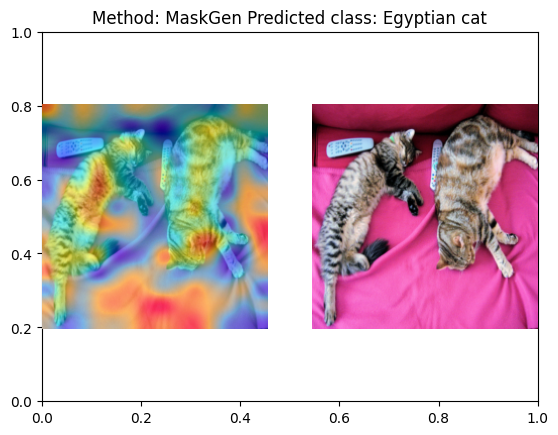

In [19]:
from maskgen.utils.img_utils import plot_overlap_np

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
size = 14
N = inputs['pixel_values'].shape[0]
sim = mask_gen_model.forward(model=pred_model, pixel_values=inputs['pixel_values'])

heatmap = torch.sigmoid(sim).reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [17]:
heatmap

array([[0.74915695, 0.6905805 , 0.5378065 , 0.7068725 , 0.63069195,
        0.576021  , 0.63035846, 0.5945771 , 0.6873237 , 0.6041165 ,
        0.6166293 , 0.72419345, 0.726588  , 0.47751728],
       [0.5937418 , 0.5554498 , 0.55848557, 0.59435576, 0.6820309 ,
        0.6008394 , 0.5397093 , 0.5961195 , 0.7188428 , 0.6679977 ,
        0.70859414, 0.51220155, 0.50366145, 0.5311277 ],
       [0.5642551 , 0.5141271 , 0.6019278 , 0.6847558 , 0.6417193 ,
        0.5640024 , 0.65047354, 0.7118615 , 0.69605696, 0.68082845,
        0.6896377 , 0.61161065, 0.57284206, 0.62269014],
       [0.5584535 , 0.5517164 , 0.5936936 , 0.56654984, 0.62906194,
        0.5544362 , 0.51614404, 0.60339814, 0.7081728 , 0.60549635,
        0.6981649 , 0.78857756, 0.5979934 , 0.47699013],
       [0.48551917, 0.56991696, 0.45704657, 0.6616029 , 0.6026855 ,
        0.5412854 , 0.61913854, 0.5952562 , 0.61715066, 0.5838225 ,
        0.6615109 , 0.6697155 , 0.54179794, 0.5251986 ],
       [0.6342374 , 0.6786102 , 0.6